# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Описание данных**

***Признаки:***

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

***Целевой признак:***

- Price — цена (евро)  


**Условия:**

    - Не ограничиваться градиентным бустингом.
    - Для оценки качества моделей применять метрику RMSE. RMSE должно быть меньше 2500.
    - Освоить библиотеку LightGBM и её средствами построить модели градиентного бустинга.
    - Ввести время выполнения ячейки кода.
    - В модели градиентного бустинга можно изменять только два-три параметра.  
    

**План исследования:**

   1. Обзор данных.  
   2. Предобработка данных.  
   3. Обучение моделей.  
   4. Выбор лучшей модели и ее тестирование.  
   5. Вывод.    

## Подготовка данных

### Откроем и сохраним файл данных

Импортируем нужные библиотеки

In [1]:
!pip install phik

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

import phik

from phik.report import plot_correlation_matrix
from phik import report

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor

from sklearn.metrics import mean_squared_error

from time import time


#import warnings
#warnings.filterwarnings("ignore")

In [2]:
# Открываем и сохраняем файл Churn.csv в датафрейм из директории или по ссылке:
try:
    df_auto = pd.read_csv('/datasets/autos.csv')
except:
    df_auto = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

### Изучим общую информацию о датафрейме

In [3]:
# Посмотрим полную информацию датафрейма:  
df_auto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
# Выведем первые десять строк датафрейма df_pdc:
df_auto.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [5]:
df_auto.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


***Вывод:*** 
- В датасете 16 столбцов и 354368 записей. Типы данных: object и int64.  
- Привести названия стобцов к стандарту PEP8.
- Признаки, не влияющиет на цену - DateCrawled, RegistrationMonth, DateCreated, NumberOfPictures, PostalCode и LastSeen.
- В признаках VehicleType, Gearbox, FuelType, Repaired, влияющих на цену, есть пропуски.
- В целевом признаке и признаке Power есть 0, наверняка есть другие выбросы.
- В RegistrationYear указан минимальный год 1000, 9999 - наверняка есть другие выбросы.
- В признаках Gearbox и NotRepaired значения можно заменить на 1/0.

### Предобработка и анализ данных:

In [6]:
# Проверим на дубликаты:
df_auto.duplicated().sum()

4

In [7]:
# Удаляем:
df_auto.drop_duplicates(inplace=True)  

In [8]:
# Выделим интересующие признаки в отдельный датафрей:
df_auto_copy = df_auto.copy()
df_auto_filtr = df_auto_copy[['VehicleType', 
                         'RegistrationYear',
                         'Gearbox', 
                         'Power',
                         'Model',
                         'Kilometer',
                         'FuelType',
                         'Brand',
                         'Repaired',
                         'Price']]

In [9]:
df_auto_filtr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       316875 non-null  object
 1   RegistrationYear  354365 non-null  int64 
 2   Gearbox           334532 non-null  object
 3   Power             354365 non-null  int64 
 4   Model             334660 non-null  object
 5   Kilometer         354365 non-null  int64 
 6   FuelType          321470 non-null  object
 7   Brand             354365 non-null  object
 8   Repaired          283211 non-null  object
 9   Price             354365 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 29.7+ MB


In [10]:
# Проверяем:
df_auto_filtr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       316875 non-null  object
 1   RegistrationYear  354365 non-null  int64 
 2   Gearbox           334532 non-null  object
 3   Power             354365 non-null  int64 
 4   Model             334660 non-null  object
 5   Kilometer         354365 non-null  int64 
 6   FuelType          321470 non-null  object
 7   Brand             354365 non-null  object
 8   Repaired          283211 non-null  object
 9   Price             354365 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 29.7+ MB


In [11]:
# Приведём названия оставшихся столбцов к стандарту PEP8:
df_auto_filtr.columns = df_auto_filtr.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]

C:\Users\Oz\AppData\Local\Temp\ipykernel_22192\2166531992.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df_auto_filtr.columns = df_auto_filtr.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]


In [12]:
df_auto_filtr.head(10)

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,price
0,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN,480
1,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes,18300
2,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN,9800
3,small,2001,manual,75,golf,150000,petrol,volkswagen,no,1500
4,small,2008,manual,69,fabia,90000,gasoline,skoda,no,3600
5,sedan,1995,manual,102,3er,150000,petrol,bmw,yes,650
6,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no,2200
7,sedan,1980,manual,50,other,40000,petrol,volkswagen,no,0
8,bus,2014,manual,125,c_max,30000,petrol,ford,NaN,14500
9,small,1998,manual,101,golf,150000,NaN,volkswagen,NaN,999


In [13]:
# Проверяем:
df_auto_filtr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   vehicle_type       316875 non-null  object
 1   registration_year  354365 non-null  int64 
 2   gearbox            334532 non-null  object
 3   power              354365 non-null  int64 
 4   model              334660 non-null  object
 5   kilometer          354365 non-null  int64 
 6   fuel_type          321470 non-null  object
 7   brand              354365 non-null  object
 8   repaired           283211 non-null  object
 9   price              354365 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 29.7+ MB


#### Целевой признак `price`.

In [14]:
# Проверим , сколько нулей в целевом признаке:
df_auto_filtr.price.value_counts()

0        10772
500       5670
1500      5394
1000      4648
1200      4594
         ...  
1368         1
233          1
11080        1
16340        1
10985        1
Name: price, Length: 3731, dtype: int64

In [15]:
# Удаляем все 0 из целевого признака:
df_auto_filtr = df_auto_filtr.query('price > 0')

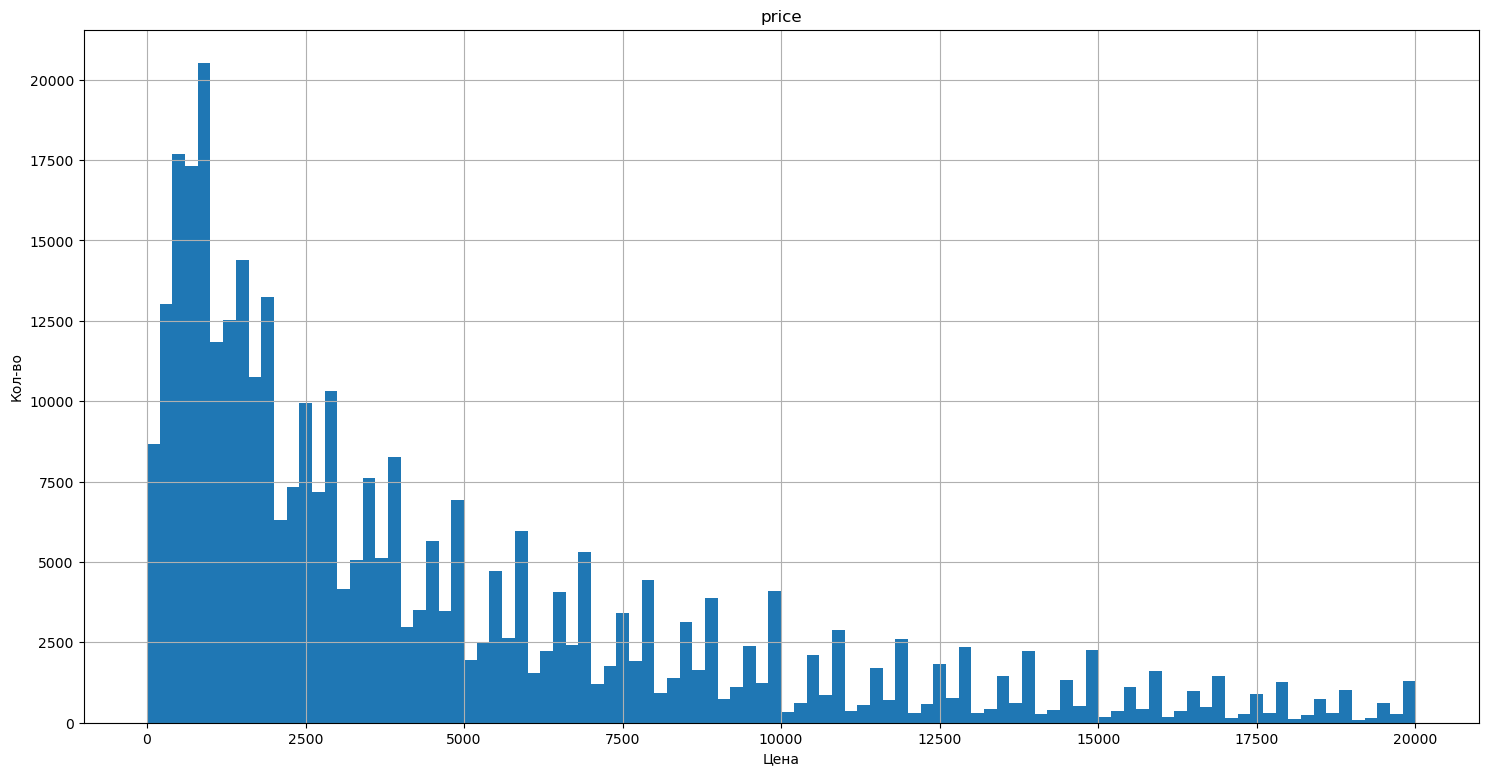

In [16]:
# Строим гистограмму распределения:
df_auto_filtr['price'].hist(bins=100, figsize=(18,9))
plt.title('price')
plt.xlabel('Цена')
plt.ylabel('Кол-во');

In [17]:
df_auto_filtr['price'].describe()

count    343593.000000
mean       4555.147363
std        4515.076200
min           1.000000
25%        1200.000000
50%        2890.000000
75%        6500.000000
max       20000.000000
Name: price, dtype: float64

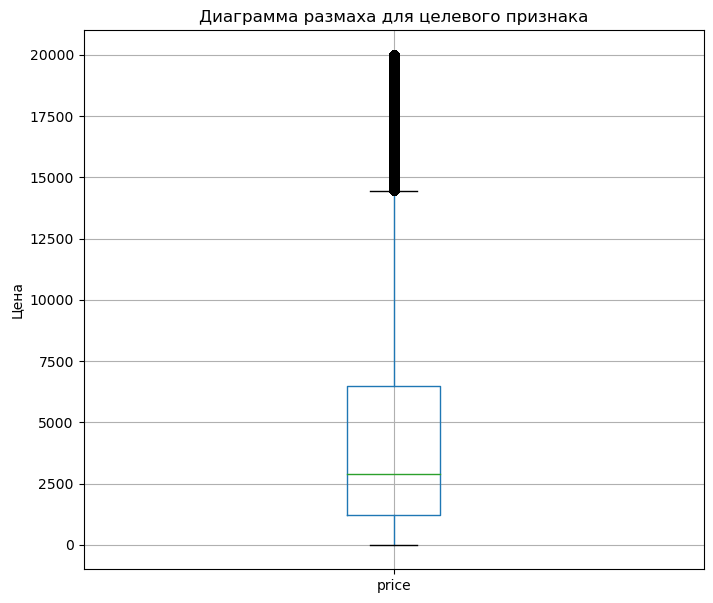

In [18]:
# Построим диаграмму размаха цены:
df_auto_filtr.boxplot(column='price', figsize=(8, 7))
plt.title('Диаграмма размаха для целевого признака')
plt.ylabel('Цена');

In [19]:
# Т.к. на гистограмме и диаграмме размаха странные данные у нуля и длинный хвост около 15000, смотрим квантили:
df_auto_filtr.price.quantile([.05, 0.95])

0.05      350.0
0.95    14800.0
Name: price, dtype: float64

In [20]:
# Выведем долю строк, где цена меньше 350 и больше 14800:
1 - df_auto_filtr.query('350 <= price <= 14800').shape[0] / df_auto_filtr.shape[0]

0.09517365021988222

In [21]:
# Удаляем 10% строк, где цена меньше 350 и больше 14800:
df_auto_filtr = df_auto_filtr.query('350 <= price <= 14800')

In [22]:
df_auto_filtr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 310892 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   vehicle_type       282228 non-null  object
 1   registration_year  310892 non-null  int64 
 2   gearbox            296768 non-null  object
 3   power              310892 non-null  int64 
 4   model              295803 non-null  object
 5   kilometer          310892 non-null  int64 
 6   fuel_type          286173 non-null  object
 7   brand              310892 non-null  object
 8   repaired           253434 non-null  object
 9   price              310892 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 26.1+ MB


#### Признак `registration_year`.

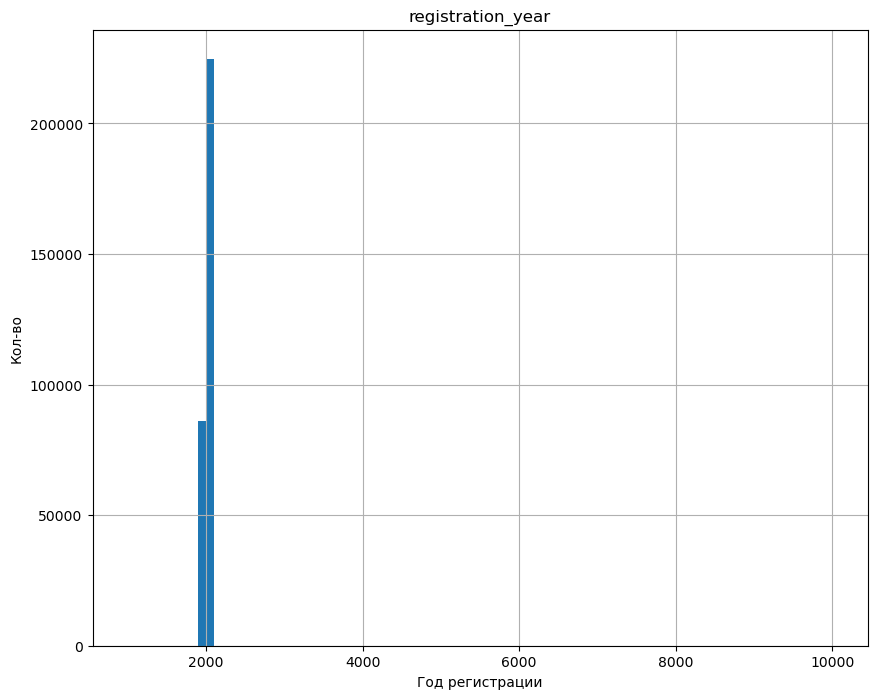

In [23]:
# Строим гистограмму распределения:
df_auto_filtr['registration_year'].hist(bins=90, figsize=(10,8))
plt.title('registration_year')
plt.xlabel('Год регистрации')
plt.ylabel('Кол-во');

In [24]:
df_auto_filtr['registration_year'].describe()

count    310892.000000
mean       2003.738794
std          65.684713
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        9999.000000
Name: registration_year, dtype: float64

Явно имеются выбросы.

In [25]:
# Посмотрим самый поздний год выгрузки:
auto_date_max = pd.to_datetime(df_auto['DateCrawled']).max()
auto_date_max

Timestamp('2016-04-07 14:36:58')

In [26]:
# Посмотрим самый ранний год регистрации автомобиля:
auto_date_min = pd.to_datetime(df_auto_filtr['registration_year']).min()
auto_date_min

Timestamp('1970-01-01 00:00:00.000001')

Даты регистрации после 2016 года некорректны, как и до 1970 - выбираем только этот диапозон.

In [27]:
df_auto_filtr = df_auto_filtr.query('1970 < registration_year < 2017')

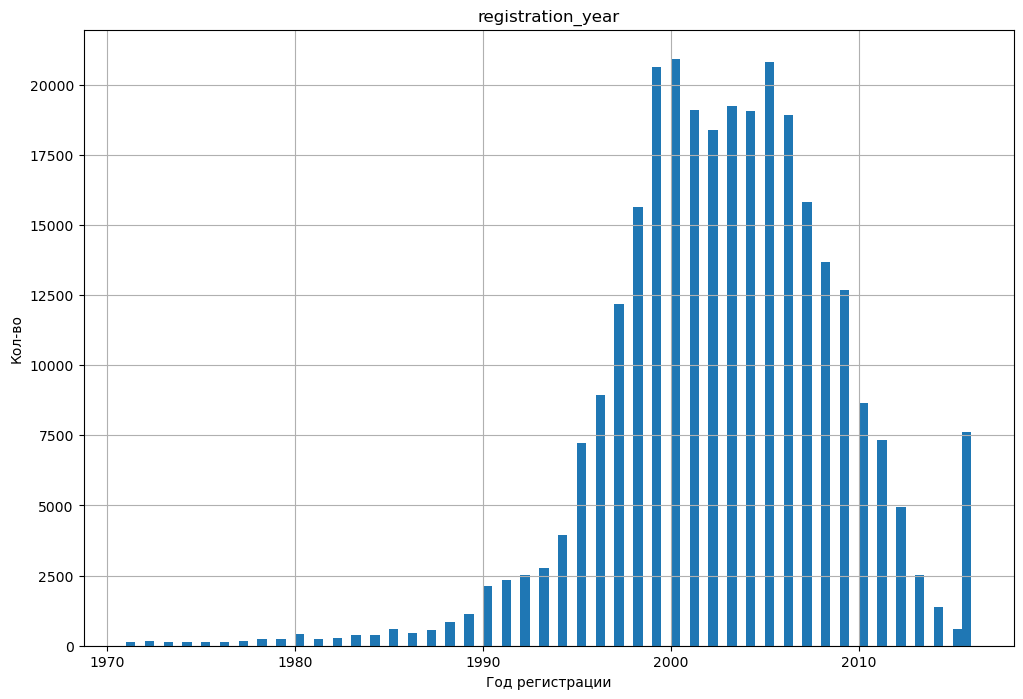

In [28]:
# Строим гистограмму распределения:
df_auto_filtr['registration_year'].hist(bins=90, figsize=(12,8))
plt.title('registration_year')
plt.xlabel('Год регистрации')
plt.ylabel('Кол-во');

In [29]:
df_auto_filtr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 296703 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   vehicle_type       281316 non-null  object
 1   registration_year  296703 non-null  int64 
 2   gearbox            284451 non-null  object
 3   power              296703 non-null  int64 
 4   model              283704 non-null  object
 5   kilometer          296703 non-null  int64 
 6   fuel_type          277231 non-null  object
 7   brand              296703 non-null  object
 8   repaired           245314 non-null  object
 9   price              296703 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 24.9+ MB


#### Признак `power`.

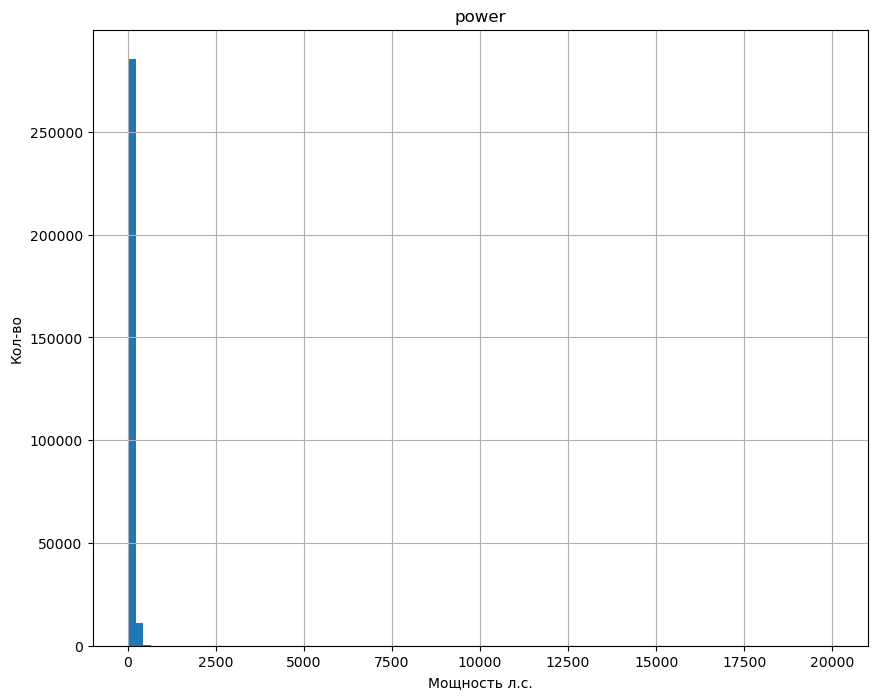

In [30]:
# Строим гистограмму распределения:
df_auto_filtr['power'].hist(bins=90, figsize=(10,8))
plt.title('power')
plt.xlabel('Мощность л.с.')
plt.ylabel('Кол-во');

In [31]:
df_auto_filtr['power'].describe()

count    296703.000000
mean        110.950253
std         184.371666
min           0.000000
25%          75.000000
50%         105.000000
75%         140.000000
max       20000.000000
Name: power, dtype: float64

Явно есть выбросы в виде 0 и свыше 1000 л.с.

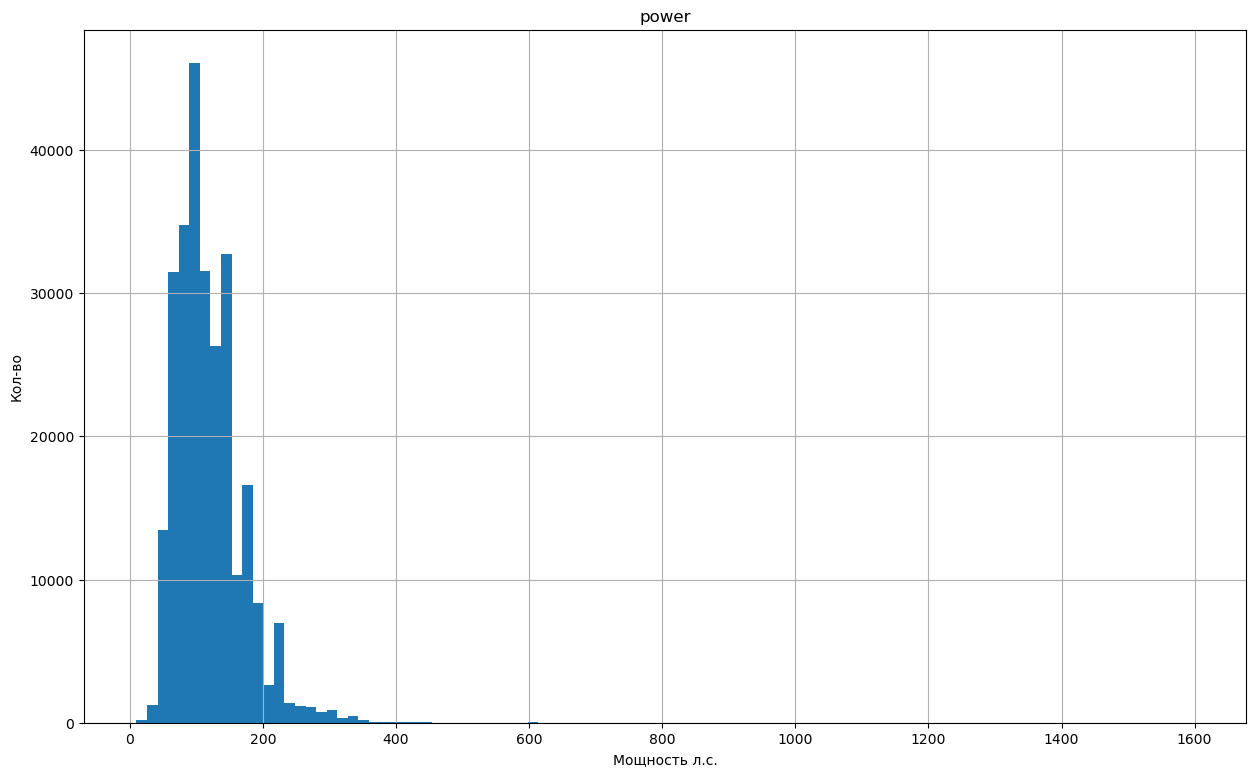

In [32]:
# Поскольку самое мощное по состоянию на 2016 год легковое авто - 1600лс,
# а самое слабое из представленных брендов авто - Citroen 2CV - имеет 9лс,
# Отбрасываем из таблицы всё, что выше и ниже этих границ:

df_auto_filtr = df_auto_filtr.query('9 < power < 1600')
df_auto_filtr['power'].hist(bins=100, figsize=(15,9))
plt.title('power')
plt.xlabel('Мощность л.с.')
plt.ylabel('Кол-во');

In [33]:
df_auto_filtr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 269450 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   vehicle_type       260245 non-null  object
 1   registration_year  269450 non-null  int64 
 2   gearbox            264752 non-null  object
 3   power              269450 non-null  int64 
 4   model              259851 non-null  object
 5   kilometer          269450 non-null  int64 
 6   fuel_type          255976 non-null  object
 7   brand              269450 non-null  object
 8   repaired           231169 non-null  object
 9   price              269450 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 22.6+ MB


#### Признак `kilometer`.

In [34]:
# Посмотрим значения в пробеге:
df_auto_filtr.kilometer.value_counts()

150000    183756
125000     29195
100000     11417
90000       9063
80000       7779
70000       6566
60000       5605
50000       4476
40000       3452
30000       2925
20000       2348
5000        2275
10000        593
Name: kilometer, dtype: int64

В признаке `kilometer` выбросов нет и аномалий нет.

#### Признак `brand`.

In [35]:
def make_barbplot(column, title):
    fig, ax = plt.subplots(figsize=(12, 5))
    pivot = pd.DataFrame(df_auto_filtr.pivot_table(index=column, aggfunc="size").sort_values(ascending=False)).head(10)
    
    sns.barplot(data=pivot, x=0, y=pivot.index)
    ax.set_title(title)
    plt.xlabel('Количество')
    plt.show()

In [36]:
# Посмотрим значения в брендах автомобилей:
df_auto_filtr.brand.value_counts()

volkswagen        58459
opel              29902
bmw               28907
mercedes_benz     24530
audi              22569
ford              18526
renault           12928
peugeot            8949
fiat               7070
seat               5413
skoda              4586
smart              4449
mazda              4446
citroen            4015
toyota             3855
nissan             3602
hyundai            2887
volvo              2568
mini               2493
mitsubishi         2286
honda              2271
kia                1912
alfa_romeo         1854
suzuki             1848
chevrolet          1355
sonstige_autos     1266
chrysler           1093
dacia               785
subaru              571
daihatsu            557
jeep                495
saab                444
porsche             397
jaguar              374
daewoo              366
land_rover          365
lancia              343
rover               328
trabant             230
lada                156
Name: brand, dtype: int64

В признаке `brand` неявных дубликатов нет.

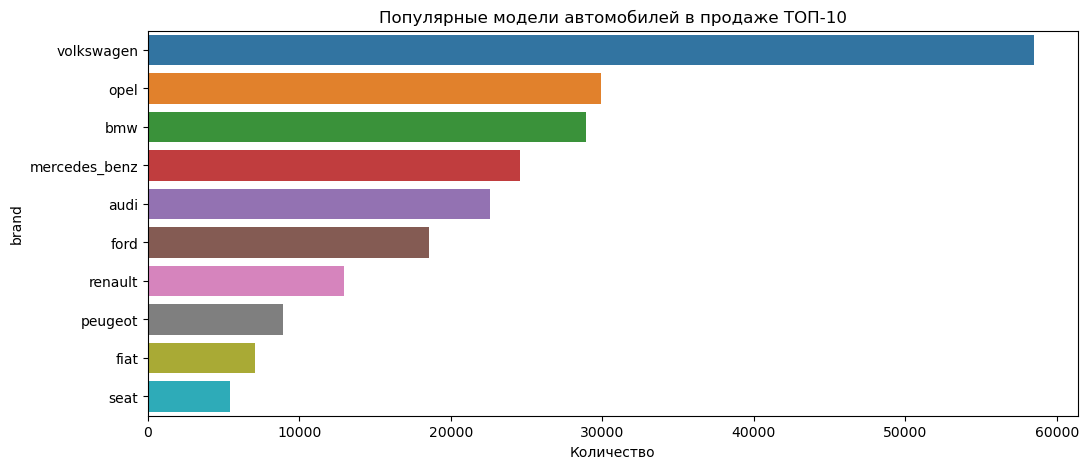

In [37]:
make_barbplot('brand', 'Популярные модели автомобилей в продаже ТОП-10')

Самая популярная марки на вторичном рынке Volkswagen, Opel, BMW и Mercedes-Benz. Наименее редкие бренды в продаже - Lada, Trabant и Rover.

#### Признак `gearbox`.

In [38]:
# Посмотрим значения в `gearbox`:
df_auto_filtr.gearbox.value_counts()

manual    214076
auto       50676
Name: gearbox, dtype: int64

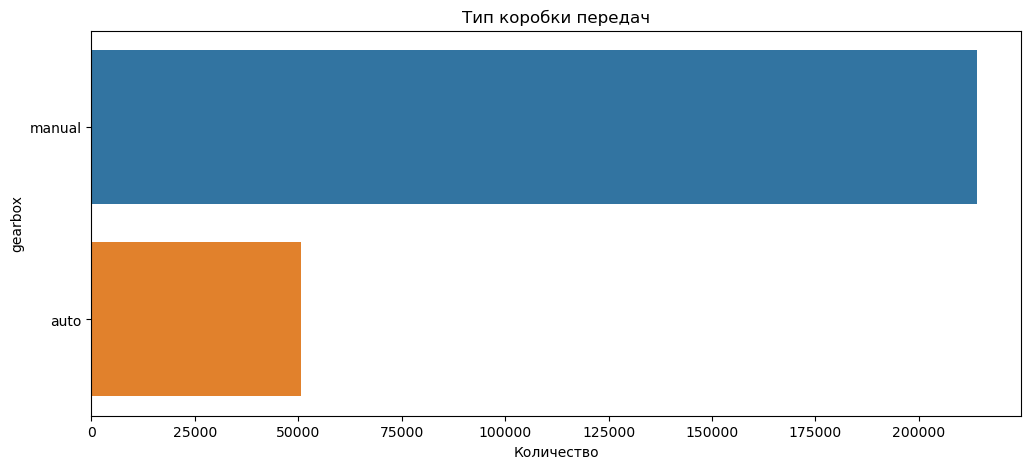

In [39]:
make_barbplot('gearbox', 'Тип коробки передач')

Большинство продавцов предпочитает механическую коробку передач.

In [40]:
# Смотрим кол-во пропусков:
df_auto_filtr.gearbox.isna().sum()

4698

In [41]:
# Заменяем NaN на 'manual':
df_auto_filtr.fillna({'gearbox':'manual'}, inplace=True)

In [42]:
# Проверим:
df_auto_filtr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 269450 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   vehicle_type       260245 non-null  object
 1   registration_year  269450 non-null  int64 
 2   gearbox            269450 non-null  object
 3   power              269450 non-null  int64 
 4   model              259851 non-null  object
 5   kilometer          269450 non-null  int64 
 6   fuel_type          255976 non-null  object
 7   brand              269450 non-null  object
 8   repaired           231169 non-null  object
 9   price              269450 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 22.6+ MB


In [43]:
# Заменим в gearbox значение manual на 1, auto - на 0:
#df_auto_filtr.loc[(df_auto_filtr.gearbox == 'manual'), 'gearbox'] = 1   
#df_auto_filtr.loc[(df_auto_filtr.gearbox == 'auto'), 'gearbox'] = 0

#### Признак `repaired`.

In [44]:
# Посмотрим значения в `repaired`:
df_auto_filtr.repaired.value_counts()

no     206275
yes     24894
Name: repaired, dtype: int64

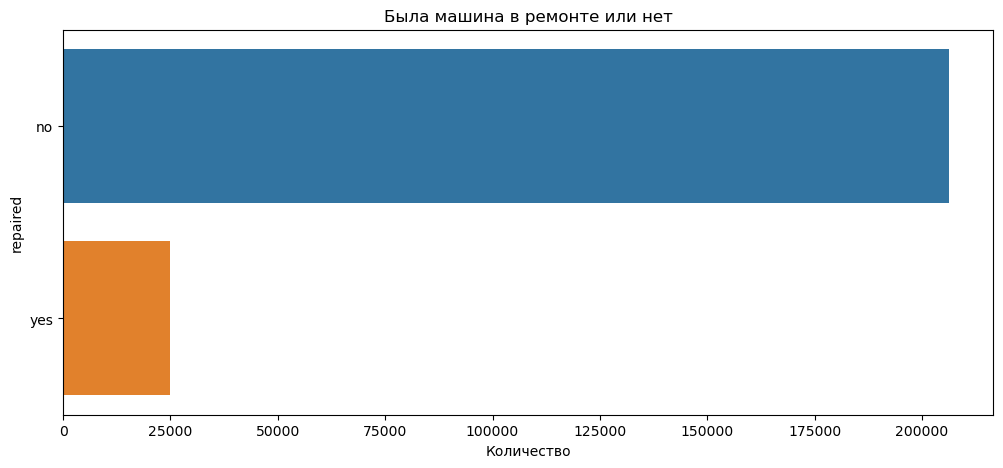

In [45]:
make_barbplot('repaired', 'Была машина в ремонте или нет')

Большинство авто не было в ремонте. (либо скрыли эту информацию)

In [46]:
# Смотрим кол-во пропусков:
df_auto_filtr.repaired.isna().sum()

38281

In [47]:
# Заменим NaN на 'yes', так как обычно любая подержанная машина была в ремонте:
df_auto_filtr.fillna({'repaired':'yes'}, inplace=True)

In [48]:
# Проверяем:
df_auto_filtr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 269450 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   vehicle_type       260245 non-null  object
 1   registration_year  269450 non-null  int64 
 2   gearbox            269450 non-null  object
 3   power              269450 non-null  int64 
 4   model              259851 non-null  object
 5   kilometer          269450 non-null  int64 
 6   fuel_type          255976 non-null  object
 7   brand              269450 non-null  object
 8   repaired           269450 non-null  object
 9   price              269450 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 22.6+ MB


In [49]:
# Заменим  в repaired значение yes на 1, no - на 0:
#df_auto_filtr.loc[(df_auto_filtr.repaired == 'yes'), 'repaired'] = 1
#df_auto_filtr.loc[(df_auto_filtr.repaired == 'no'), 'repaired'] = 0

#### Признак `model`.

In [50]:
# Посмотрим значения в `model`:
df_auto_filtr.model.value_counts()

golf                  22613
other                 18166
3er                   16108
polo                   9730
corsa                  9049
                      ...  
serie_2                   2
range_rover_evoque        2
serie_3                   2
gl                        2
rangerover                1
Name: model, Length: 249, dtype: int64

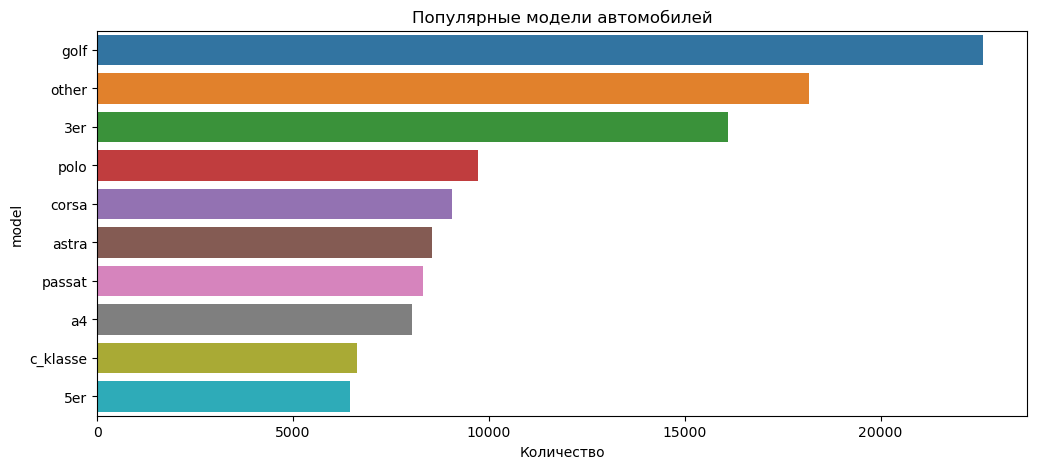

In [51]:
make_barbplot('model', 'Популярные модели автомобилей')

Самая популярная модель авто - golf, также заметим, что у нас много неизвестных нам моделей. (other)

In [52]:
# Смотрим кол-во пропусков:
df_auto_filtr.model.isna().sum()

9599

In [53]:
# Заменяю NaN на 'unknown':
df_auto_filtr.fillna({'model':'unknown'}, inplace=True)

In [54]:
# Проверяем:
df_auto_filtr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 269450 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   vehicle_type       260245 non-null  object
 1   registration_year  269450 non-null  int64 
 2   gearbox            269450 non-null  object
 3   power              269450 non-null  int64 
 4   model              269450 non-null  object
 5   kilometer          269450 non-null  int64 
 6   fuel_type          255976 non-null  object
 7   brand              269450 non-null  object
 8   repaired           269450 non-null  object
 9   price              269450 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 22.6+ MB


#### Признак `vehicletype`.

In [55]:
# Посмотрим значения в `vehicle_type`:
df_auto_filtr.vehicle_type.value_counts()

sedan          76521
small          64710
wagon          54754
bus            24467
convertible    16493
coupe          12387
suv             8705
other           2208
Name: vehicle_type, dtype: int64

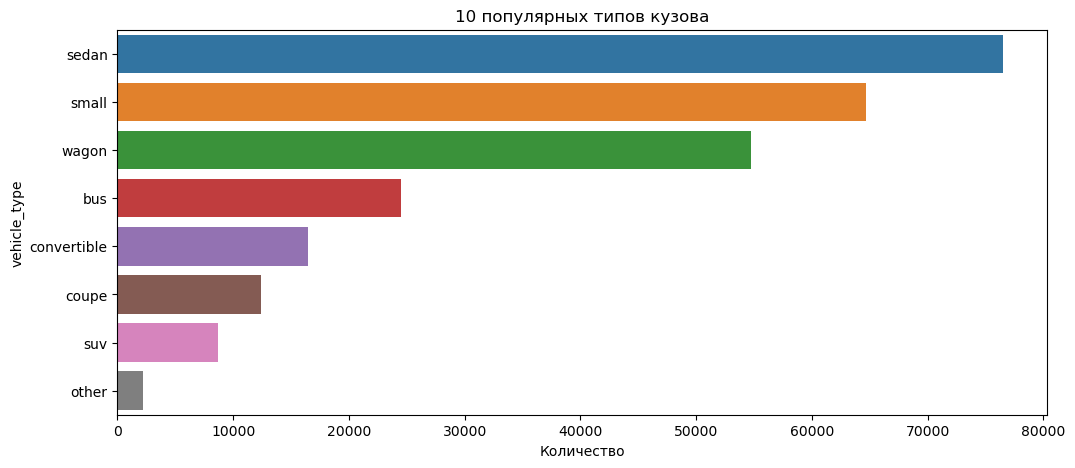

In [56]:
make_barbplot('vehicle_type', '10 популярных типов кузова')

Самый популярный тип автомобильного кузова - sedan.

In [57]:
# Смотрим кол-во пропусков:
df_auto_filtr.vehicle_type.isna().sum()

9205

In [58]:
# Заменяем пропуски на unknown:
df_auto_filtr.fillna({'vehicle_type':'unknown'}, inplace=True)

In [59]:
# Проверяем:
df_auto_filtr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 269450 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   vehicle_type       269450 non-null  object
 1   registration_year  269450 non-null  int64 
 2   gearbox            269450 non-null  object
 3   power              269450 non-null  int64 
 4   model              269450 non-null  object
 5   kilometer          269450 non-null  int64 
 6   fuel_type          255976 non-null  object
 7   brand              269450 non-null  object
 8   repaired           269450 non-null  object
 9   price              269450 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 22.6+ MB


#### Признак `fueltype`.

In [60]:
# Посмотрим значения в `fuel_type`:
df_auto_filtr.fuel_type.value_counts()

petrol      172044
gasoline     78652
lpg           4533
cng            468
hybrid         154
other           70
electric        55
Name: fuel_type, dtype: int64

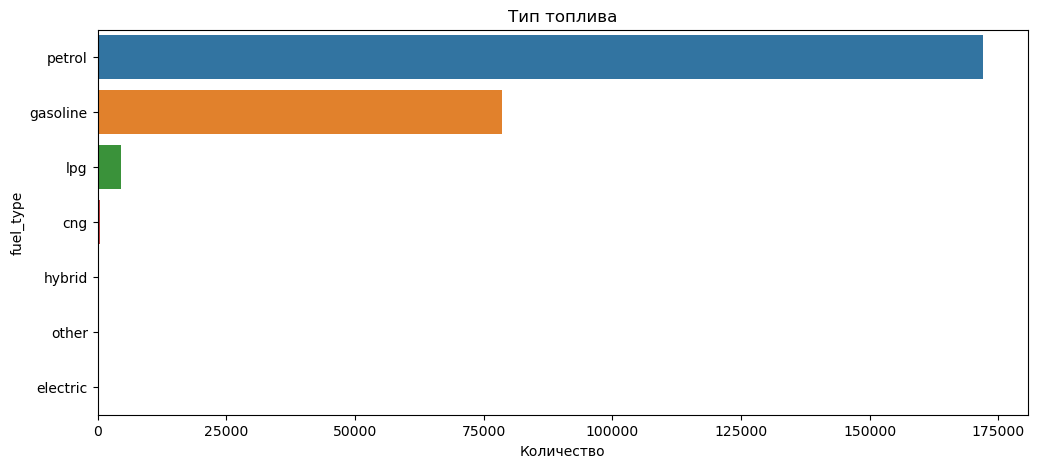

In [61]:
make_barbplot('fuel_type', 'Тип топлива')

Большинство авто на бензине.

In [62]:
# Смотрим кол-во пропусков:
df_auto_filtr.fuel_type.isna().sum()

13474

In [63]:
# Заменяем пропуски на unknown:
df_auto_filtr.fillna({'fuel_type':'unknown'}, inplace=True)

In [64]:
# Проверяем:
df_auto_filtr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 269450 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   vehicle_type       269450 non-null  object
 1   registration_year  269450 non-null  int64 
 2   gearbox            269450 non-null  object
 3   power              269450 non-null  int64 
 4   model              269450 non-null  object
 5   kilometer          269450 non-null  int64 
 6   fuel_type          269450 non-null  object
 7   brand              269450 non-null  object
 8   repaired           269450 non-null  object
 9   price              269450 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 22.6+ MB


#### Downcast

Применим downcast, чтобу уменьшить потребление памяти и ускорить работу.

In [65]:
#df_auto_filtr['repaired'] = pd.to_numeric(df_auto_filtr['repaired'], downcast='integer')
#df_auto_filtr['gearbox'] = pd.to_numeric(df_auto_filtr['gearbox'], downcast='integer')
df_auto_filtr['registration_year'] = pd.to_numeric(df_auto_filtr['registration_year'], downcast='integer')
df_auto_filtr['power'] = pd.to_numeric(df_auto_filtr['power'], downcast='integer')
df_auto_filtr['kilometer'] = pd.to_numeric(df_auto_filtr['kilometer'], downcast='integer')
df_auto_filtr['price'] = pd.to_numeric(df_auto_filtr['price'], downcast='integer')
df_auto_filtr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 269450 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   vehicle_type       269450 non-null  object
 1   registration_year  269450 non-null  int16 
 2   gearbox            269450 non-null  object
 3   power              269450 non-null  int16 
 4   model              269450 non-null  object
 5   kilometer          269450 non-null  int32 
 6   fuel_type          269450 non-null  object
 7   brand              269450 non-null  object
 8   repaired           269450 non-null  object
 9   price              269450 non-null  int16 
dtypes: int16(3), int32(1), object(6)
memory usage: 17.0+ MB


In [66]:
df_auto_filtr.loc[:, df_auto_filtr.dtypes == 'object'] =\
    df_auto_filtr.select_dtypes(['object'])\
    .apply(lambda x: x.astype('category'))

df_auto_filtr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 269450 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   vehicle_type       269450 non-null  category
 1   registration_year  269450 non-null  int16   
 2   gearbox            269450 non-null  category
 3   power              269450 non-null  int16   
 4   model              269450 non-null  category
 5   kilometer          269450 non-null  int32   
 6   fuel_type          269450 non-null  category
 7   brand              269450 non-null  category
 8   repaired           269450 non-null  category
 9   price              269450 non-null  int16   
dtypes: category(6), int16(3), int32(1)
memory usage: 6.4 MB


C:\Users\Oz\AppData\Local\Temp\ipykernel_22192\3902490743.py:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_auto_filtr.loc[:, df_auto_filtr.dtypes == 'object'] =\


In [67]:
print(f'Будем использовать {round(df_auto_filtr.shape[0] / df_auto.shape[0] * 100, 3)}% от начальной выборки')

Будем использовать 76.037% от начальной выборки


#### Распределение колличественных данных:

In [68]:
def price_plot(feature, title):
    mean_price = df_auto_filtr[[feature, 'price']].groupby(feature, as_index=False).mean().astype('int')
    plt.figure(figsize=(12,6))
    plt.grid(axis = 'both')
    
    sns.lineplot(x=feature, y='price', data=mean_price)
    plt.xlabel(feature, size=12)
    plt.ylabel('Средняя цена', size=12)
    plt.title(title, size=15, y=1.02)
    plt.show()

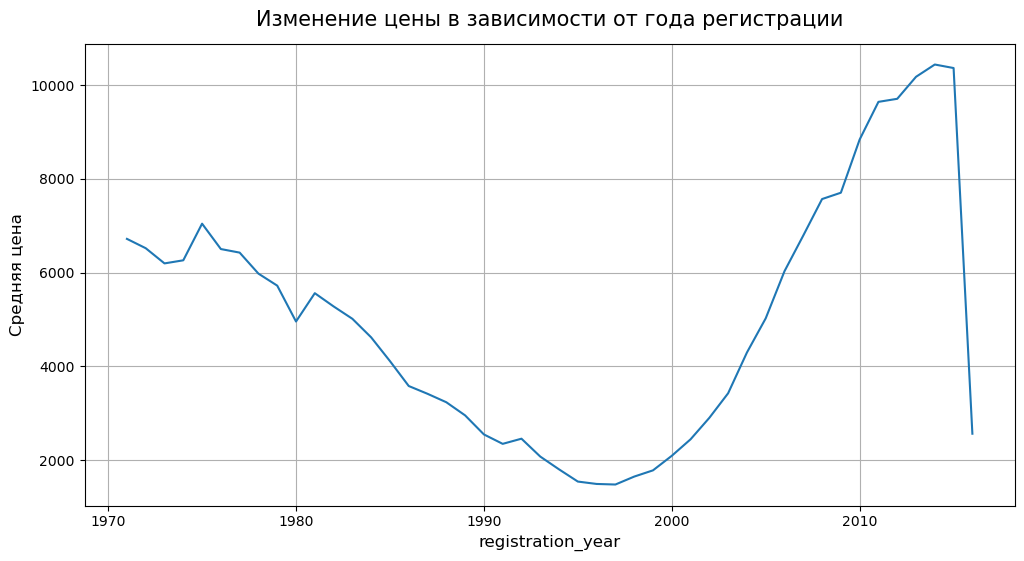

In [69]:
price_plot('registration_year', 'Изменение цены в зависимости от года регистрации')

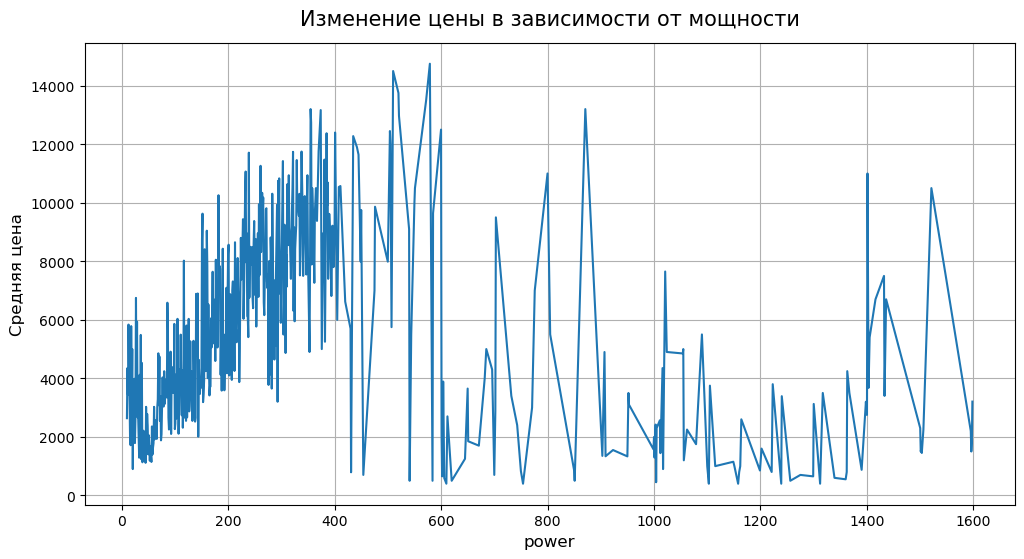

In [70]:
price_plot('power', 'Изменение цены в зависимости от мощности')

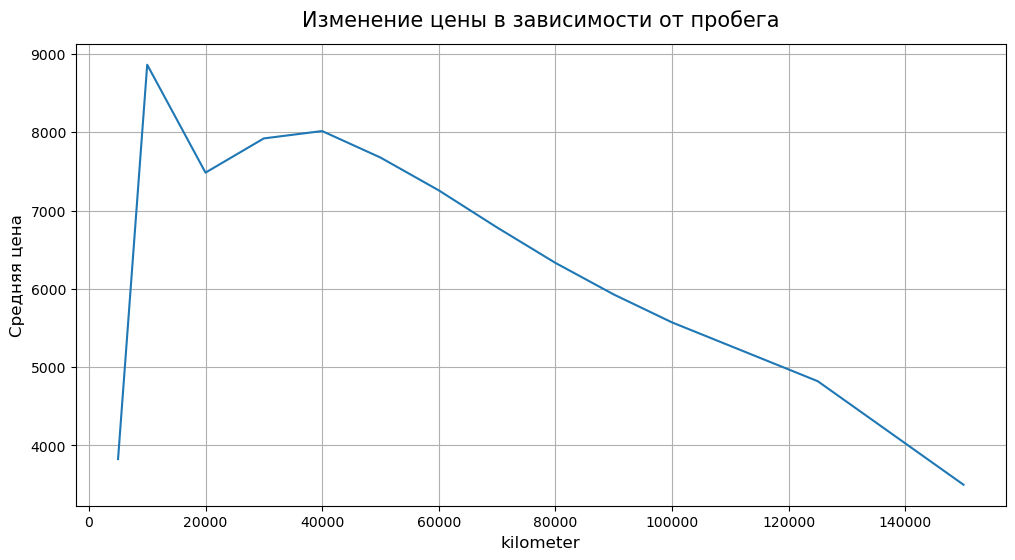

In [71]:
price_plot('kilometer', 'Изменение цены в зависимости от пробега')

#### Корреляция

C:\Users\Oz\AppData\Local\Temp\ipykernel_22192\2181879045.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_auto_filtr.corr()


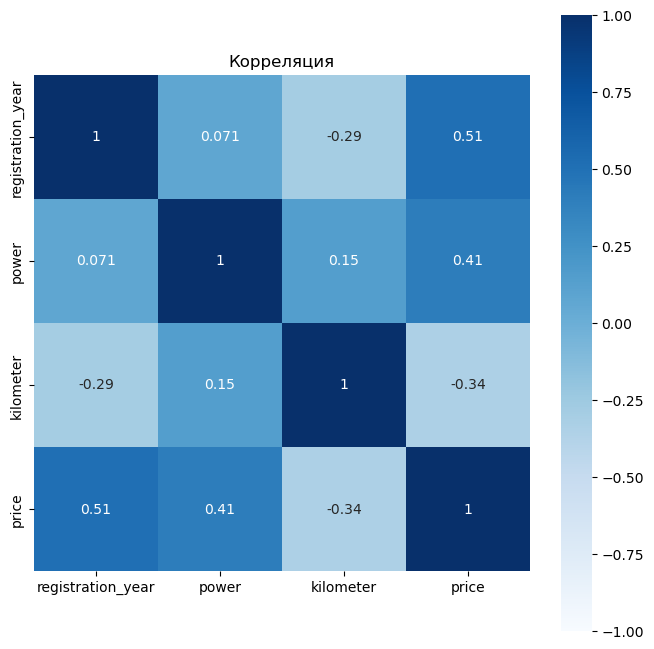

In [72]:
corr = df_auto_filtr.corr()

fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(corr, annot=True, square=True, vmin=-1, vmax=1, cmap="Blues")
plt.title('Корреляция')
plt.show()

В цена логично зависит:
 - прямо пропорционально от года регистрации, мощности.
 - обратно пропорционально от пробега.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

*Добавил.*
</div>

In [73]:
phik_overview = df_auto_filtr.phik_matrix(interval_cols = ['power', 'price'])

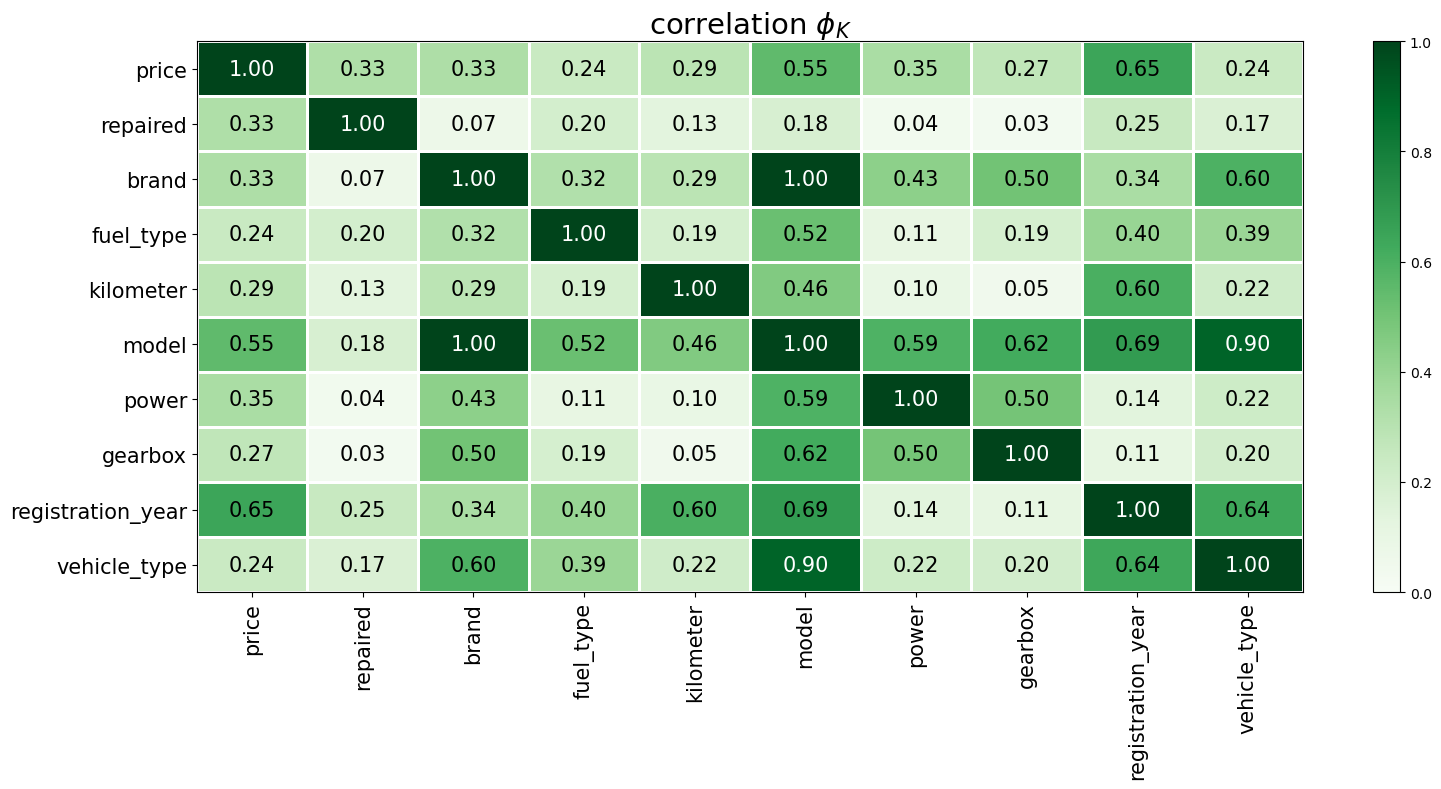

In [74]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(16, 8))
plt.tight_layout()

#### ***Вывод:***
- Привели названия стобцов к стандарту PEP8.
- Избавились от:
     - признаков, которые никак не влияют на целевой признак - DateCrawled, RegistrationMonth, DateCreated, NumberOfPictures, PostalCode и LastSeen;
     - дубликатов;
     - выбросов в целевом признаке и признаках.
- Заполнили пропуски в:
     - gearbox значением 'manual';
     - repaired значением 'yes';
     - model, vehicletype, fueltype значением 'unknown'.
- Целевой признак логично зависит от, по убыванию: от года регистрации, модели, мощности, ремонта, бренда, пробега , типа коробки, типа топлива и типа кузова.
- В результате обработки данных датафрейм сократился примерно на 24%, однако данных (269450 строк) достаточно для обучения моделей.

## Обучение моделей

In [75]:
# Dыделяем признаки и целевой признак:
features_orig = df_auto_filtr.drop('price', axis=1)
target = df_auto_filtr.price

In [76]:
# Разбиваем данные на три выборки: обучающую, валидационную и тестовую в соотношении 75/25:
features_train, features_test, target_train, target_test = train_test_split(features_orig,
                                                                          target,
                                                                          test_size=.25,
                                                                          random_state=13524)

In [77]:
# Смотрим размеры выборок на кодированных данных:
for i in [features_train, features_test, target_train, target_test]:
    print(i.shape)

(202087, 9)
(67363, 9)
(202087,)
(67363,)


In [81]:
categorial = ['fuel_type', 'repaired', 'gearbox', 'vehicle_type', 'brand', 'model']
numeric = ['power', 'kilometer', 'registration_year']

In [82]:
# Кодируем признаки через OE:
encoder_oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

encoder_oe.fit(features_train[categorial])

tmp_train_oe = pd.DataFrame(encoder_oe.transform(features_train[categorial]), 
                                   columns=encoder_oe.get_feature_names_out(),
                                   index=features_train.index)
tmp_test_oe = pd.DataFrame(encoder_oe.transform(features_test[categorial]), 
                                   columns=encoder_oe.get_feature_names_out(),
                                   index=features_test.index)


features_train_oe = features_train[numeric].join(tmp_train_oe)
features_test_oe = features_test[numeric].join(tmp_test_oe)


`Kilometer` и `RegistrationYear` имеет распределение категориального признака, так как задано небольшое количество уникальных значений - с ним также стоит работать как с категорией.  
    
*Не смотря на то, что эти признаки дискретные, попробовал обработать их как категориальные. При обработке этих признаков модели с кодированием OE, как с категорией, ухудшило время обучения моделей в два раза и увеличило RMSE на 0,3. Более того при обработке этих признаков с кодированием OHE, как с категорией, выдает в LinearRegression значение RMSE = 716821628.0342815, что явно ухудшает модель. Что приводит к выводу, что рассматривать данные признаки надо, как количественные.*


In [83]:
target_train_oe = target_train.copy()
target_test_oe = target_test.copy()

In [84]:
# Смотрим размеры выборок на кодированных данных:
for i in [features_train_oe, features_test_oe, target_train_oe, target_test_oe]:
    print(i.shape)

(202087, 9)
(67363, 9)
(202087,)
(67363,)


In [85]:
# Кодируем признаки через OHE:

tmp_train = features_train[categorial]
tmp_test= features_test[categorial]


encoder_ohe = OneHotEncoder(handle_unknown='ignore')
encoder_ohe.fit(features_train[categorial])

tmp_train = pd.DataFrame(encoder_ohe.transform(features_train[categorial]).toarray(), 
                                   columns=encoder_ohe.get_feature_names_out(),
                                   index=features_train.index)
tmp_test = pd.DataFrame(encoder_ohe.transform(features_test[categorial]).toarray(), 
                                   columns=encoder_ohe.get_feature_names_out(),
                                   index=features_test.index)


features_train_ohe = features_train[numeric].join(tmp_train)
features_test_ohe = features_test[numeric].join(tmp_test)

In [86]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [87]:
target_train_ohe = target_train.copy()
target_test_ohe = target_test.copy()

In [88]:
# Смотрим размеры выборок на кодированных данных OHE:
for i in [features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe]:
    print(i.shape)

(202087, 314)
(67363, 314)
(202087,)
(67363,)


### Модель LinearRegression

#### На выборках c OneHotEncoder:

In [89]:
%%time

# MSE доступна только как neg_mean_squared_error, которая возвращает массив отрицательных значений
# поэтому  домножаем на -1:

model_lr = LinearRegression()
rmse_lr_ohe_cv = (cross_val_score(model_lr, 
                             features_train_ohe, 
                             target_train_ohe, 
                             cv=5, 
                             scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Mean RMSE from CV of LinearRegression =', rmse_lr_ohe_cv)

Mean RMSE from CV of LinearRegression = 2100.0277016936793
CPU times: total: 32.2 s
Wall time: 5.85 s


In [90]:
%%time

start = time()

model_lr = LinearRegression()
model_lr.fit(features_train_ohe, target_train_ohe)

end = time()
model_lr_ohe_fit_time = (end-start)

CPU times: total: 8.39 s
Wall time: 1.31 s


In [91]:
%%time

start = time()

target_predict = model_lr.predict(features_train_ohe)

end = time()
model_lr_ohe_predict_time = (end-start)

CPU times: total: 156 ms
Wall time: 134 ms


In [92]:
#%%time
#rmse_lr_ohe = mean_squared_error(target_train, target_predict) ** .5
#print('RMSE_LinearRegression_OHE =', rmse_lr_ohe)

### Модель CatBoostRegressor:

#### На выборках c OrdinalEncode:

In [93]:
%%time

# Подбираем гиперпараметры

model_cbr = CatBoostRegressor(random_state=13524, verbose=False) 
parameters = [{'learning_rate':[.1, .5, .8], 'iterations':[100, 200, 300]}]
clf = GridSearchCV(model_cbr, parameters, scoring='neg_mean_squared_error')
clf.fit(features_train_oe, target_train_oe)

print(clf.best_params_)
print()

means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

rmse_cbr_oe_cv = (max(means) * -1) ** .5
print('RMSE =', rmse_cbr_oe_cv)

{'iterations': 300, 'learning_rate': 0.5}

1509.424410 for {'iterations': 100, 'learning_rate': 0.1}
1396.414641 for {'iterations': 100, 'learning_rate': 0.5}
1394.973104 for {'iterations': 100, 'learning_rate': 0.8}
1443.155185 for {'iterations': 200, 'learning_rate': 0.1}
1365.717338 for {'iterations': 200, 'learning_rate': 0.5}
1370.229253 for {'iterations': 200, 'learning_rate': 0.8}
1413.202267 for {'iterations': 300, 'learning_rate': 0.1}
1350.303296 for {'iterations': 300, 'learning_rate': 0.5}
1360.088676 for {'iterations': 300, 'learning_rate': 0.8}

RMSE = 1350.3032957974558
CPU times: total: 8min 21s
Wall time: 43.5 s


In [94]:
%%time

start = time()

model_cbr = CatBoostRegressor(learning_rate=.5, random_state=13524, verbose=False)
model_cbr.fit(features_train_oe, target_train_oe)

end = time()
model_cbr_oe_fit_time = (end-start)

CPU times: total: 1min 1s
Wall time: 5.18 s


In [95]:
%%time

start = time()

target_predict = model_cbr.predict(features_train_oe)

end = time()
model_cbr_oe_predict_time = (end-start)

CPU times: total: 31.2 ms
Wall time: 22.8 ms


In [96]:
#rmse_cbr_oe = mean_squared_error(target_train_oe, target_predict) ** .5
#print('RMSE_CatBoostRegressor_OE =', rmse_cbr_oe)

#### На выборках без OE:

In [97]:
%%time

# Подбираем гиперпараметры

model_cbr = CatBoostRegressor(random_state=13524, verbose=False, 
                              cat_features=['vehicle_type','fuel_type','brand','model', 'gearbox', 'repaired']) 
parameters = [{'learning_rate':[.1, .5, .8], 'iterations':[100, 200, 300]}]
clf_ = GridSearchCV(model_cbr, parameters, scoring='neg_mean_squared_error')
clf_.fit(features_train, target_train)

print(clf_.best_params_)

print()

means = clf_.cv_results_['mean_test_score']
stds = clf_.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf_.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

rmse_cbr_cv = (max(means) * -1) ** .5
print('RMSE =', rmse_cbr_cv)

{'iterations': 300, 'learning_rate': 0.5}

1479.135303 for {'iterations': 100, 'learning_rate': 0.1}
1393.067719 for {'iterations': 100, 'learning_rate': 0.5}
1393.316263 for {'iterations': 100, 'learning_rate': 0.8}
1413.780975 for {'iterations': 200, 'learning_rate': 0.1}
1362.691950 for {'iterations': 200, 'learning_rate': 0.5}
1369.705083 for {'iterations': 200, 'learning_rate': 0.8}
1390.408715 for {'iterations': 300, 'learning_rate': 0.1}
1351.729307 for {'iterations': 300, 'learning_rate': 0.5}
1362.007695 for {'iterations': 300, 'learning_rate': 0.8}

RMSE = 1351.7293070721194
CPU times: total: 30min 20s
Wall time: 5min 18s


In [98]:
%%time

start = time()

model_cbr = CatBoostRegressor(learning_rate=.5, iterations=300, random_state=13524, verbose=False, 
                              cat_features=['vehicle_type','fuel_type','brand','model', 'gearbox', 'repaired']) 

model_cbr.fit(features_train, target_train)

end = time()
model_cbr_fit_time = (end-start)

CPU times: total: 1min 12s
Wall time: 12.8 s


In [99]:
%%time

start = time()

target_predict = model_cbr.predict(features_train)

end = time()
model_cbr_predict_time = (end-start)

CPU times: total: 344 ms
Wall time: 87.2 ms


In [100]:
#rmse_cbr = mean_squared_error(target_train, target_predict) ** .5
#print('RMSE_CatBoostRegressor =', rmse_cbr)

### Модель LightGBMRegressor:

In [101]:
%%time

# Подбираем гиперпараметры
model_lgbmr = LGBMRegressor(random_state=13524) 
parameters = [{'num_leaves':[25, 50, 100, 200, 400], 'learning_rate':[.1, .3, .5]}]

clf = GridSearchCV(model_lgbmr, parameters, scoring='neg_mean_squared_error')
clf.fit(features_train, target_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
#print()

means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

rsme_lgbmr_cv = (max(means) * -1) ** .5
print('RMSE =', rsme_lgbmr_cv)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003937 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 622
[LightGBM] [Info] Number of data points in the train set: 161669, number of used features: 9
[LightGBM] [Info] Start training from score 4282.304635
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002528 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 623
[LightGBM] [Info] Number of data points in the train set: 161669, number of used features: 9
[LightGBM] [Info] Start training from score 4281.890226
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002709 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003130 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 623
[LightGBM] [Info] Number of data points in the train set: 161669, number of used features: 9
[LightGBM] [Info] Start training from score 4281.890226
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003249 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 620
[LightGBM] [Info] Number of data points in the train set: 161670, number of used features: 9
[LightGBM] [Info] Start training from score 4279.425793
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002426 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002513 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 620
[LightGBM] [Info] Number of data points in the train set: 161670, number of used features: 9
[LightGBM] [Info] Start training from score 4279.425793
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002374 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 620
[LightGBM] [Info] Number of data points in the train set: 161670, number of used features: 9
[LightGBM] [Info] Start training from score 4282.791142
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003016 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 620
[LightGBM] [Info] Number of data points in the train set: 161670, number of used features: 9
[LightGBM] [Info] Start training from score 4282.791142
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001859 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 623
[LightGBM] [Info] Number of data points in the train set: 161670, number of used features: 9
[LightGBM] [Info] Start training from score 4279.023870
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002627 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

In [102]:
%%time

start = time()

model_lgbmr = LGBMRegressor(learning_rate=.1, 
                            num_leaves=400,
                            random_state=13524)
model_lgbmr.fit(features_train, target_train)

end = time()
model_lgbmr_fit_time = (end-start)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002965 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 623
[LightGBM] [Info] Number of data points in the train set: 202087, number of used features: 9
[LightGBM] [Info] Start training from score 4281.087131
CPU times: total: 9.38 s
Wall time: 936 ms


In [103]:
%%time

start = time()

target_predict = model_lgbmr.predict(features_train)

end = time()
model_lgbmr_predict_time = (end-start)

CPU times: total: 3.12 s
Wall time: 314 ms


In [104]:
#rsme_lgbmr = mean_squared_error(target_train, target_predict) ** .5
#print('RMSE_LightGBMRegressor =', rsme_lgbmr)

### Модель DecisionTreeRegressor:

In [105]:
%%time

model_dtr = DecisionTreeRegressor(random_state=13524) 
max_depth_list = [x for x in range(2, 20)]
hyperparams = [{ 
                'max_depth':max_depth_list}]

clf = GridSearchCV(model_dtr, hyperparams, scoring='neg_mean_squared_error')
clf.fit(features_train_oe, target_train_oe)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

rmse_dtr_oe_cv = (max(means)*-1) ** 0.5
print('RMSE =', rmse_dtr_oe_cv)

Best parameters set found on development set:

{'max_depth': 13}

Grid scores on development set:

2564.919159 for {'max_depth': 2}
2377.396166 for {'max_depth': 3}
2142.523645 for {'max_depth': 4}
1990.080233 for {'max_depth': 5}
1883.061149 for {'max_depth': 6}
1802.424089 for {'max_depth': 7}
1733.134290 for {'max_depth': 8}
1679.343960 for {'max_depth': 9}
1634.028859 for {'max_depth': 10}
1598.162654 for {'max_depth': 11}
1575.832304 for {'max_depth': 12}
1567.901962 for {'max_depth': 13}
1569.007770 for {'max_depth': 14}
1573.734708 for {'max_depth': 15}
1583.370867 for {'max_depth': 16}
1588.125694 for {'max_depth': 17}
1601.656200 for {'max_depth': 18}
1612.029296 for {'max_depth': 19}

RMSE = 1567.9019617102228
CPU times: total: 19.6 s
Wall time: 19.1 s


In [106]:
%%time
start = time()
# Модель на принаках, закодированных по методу OHE
model = DecisionTreeRegressor(max_depth=13, 
                              random_state=13524) 
model.fit(features_train_oe, target_train_oe)

end = time()
model_dtr_fit_time = (end-start)

CPU times: total: 281 ms
Wall time: 275 ms


In [107]:
%%time

start = time()

target_predict = model.predict(features_train_oe)

end = time()
model_dtr_predict_time = (end-start)

CPU times: total: 31.2 ms
Wall time: 25.6 ms


In [108]:
#rmse_dtr_oe = mean_squared_error(target_train_oe, target_predict) ** 0.5 
#print('RMSE_DecisionTreeRegressor_OE =', rmse_dtr_oe)

## Анализ моделей

In [109]:
# Создаем промежуточную сводную таблицу по показателям RMSE < 2500, время обучения модели и время предсказания модели:

index = ['Линейная регрессия с OHE',
         'CatBoostRegressor с OE',
         'CatBoostRegressor',
         'LGBMRegressor',
         'DecisionTreeRegressor с OE']

data = {'RMSE':[rmse_lr_ohe_cv,
                rmse_cbr_oe_cv,
                rmse_cbr_cv,
                rsme_lgbmr_cv,
                rmse_dtr_oe_cv],
        
        'Время обучения модели':[model_lr_ohe_fit_time,
                                 model_cbr_oe_fit_time, 
                                 model_cbr_fit_time,
                                 model_lgbmr_fit_time,
                                 model_dtr_fit_time],
        
        'Время предсказания модели':[model_lr_ohe_predict_time,
                                     model_cbr_oe_predict_time,
                                     model_cbr_predict_time,
                                     model_lgbmr_predict_time,
                                     model_dtr_predict_time]
       }

kpi_data = pd.DataFrame(data=data, index=index)

# Добавляем столбец Рейтинг с весами:

kpi_data['Рейтинг'] = (kpi_data['RMSE'] * .34 \
                       + kpi_data['Время обучения модели'] * .33 \
                       + kpi_data['Время предсказания модели'] * .33)

kpi_data.sort_values(by = 'Рейтинг', ascending=True)

,RMSE,Время обучения модели,Время предсказания модели,Рейтинг
LGBMRegressor,1295.083436,0.935521,0.313972,440.740701
CatBoostRegressor с OE,1350.303296,5.175648,0.022820,460.818615
CatBoostRegressor,1351.729307,12.791781,0.087246,463.838043
DecisionTreeRegressor с OE,1567.901962,0.274717,0.025583,533.185766
Линейная регрессия с OHE,2100.027702,1.314735,0.133503,714.487337


###### ***Вывод, предварительный:***
Все модели уложились в значение метрики RMSE < 2500. Лучшей моделью по RMSE, времени обучения модели, времени предсказания модели, если считать эти параметры одинаково важными для принятия решения, является LGBMRegressor. Аутсайдер рейтинга - модель LinearRegression.

**Тестирование лучшей модели:**

In [110]:
start = time()

target_predict = model_lgbmr.predict(features_test)

end = time()
model_lgbmr_predict_time = (end-start)

In [111]:
rsme_lgbmr_test = mean_squared_error(target_test, target_predict) ** .5
print('RMSE =', rsme_lgbmr_test)

RMSE = 1272.801218366453


**Проверим модель на адекватность**

In [112]:
%%time
# Проверяем на модели DummyRegressor:

start = time()

dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features_train, target_train)

end = time()
model_dr_fit_time = (end-start)

CPU times: total: 0 ns
Wall time: 0 ns


In [113]:
start = time()

target_predict = dummy_regr.predict(features_test)

end = time()
model_dr_predict_time = (end-start)

In [114]:
rsme_dr = mean_squared_error(target_test, target_predict)**0.5
print('RMSE =', rsme_dr)

RMSE = 3594.427997748805


In [115]:
# Создаем сводную таблицу по показателям RMSE < 2500, время обучения модели и время предсказания модели :

index = ['LGBMRegressor',
         'DummyRegressor'
        ]

data = {'RMSE':[rsme_lgbmr_test,
                rsme_dr],
        
        'Время обучения модели':[model_lgbmr_fit_time,
                                 model_dr_fit_time],
        
        'Время предсказания модели':[model_lgbmr_predict_time,
                                     model_dr_predict_time]
       }

kpi_data = pd.DataFrame(data=data, index=index)

# Добавляем столбец Рейтинг с весами:

kpi_data['Рейтинг'] = (kpi_data['RMSE'] * .34 \
                       + kpi_data['Время обучения модели'] * .33 \
                       + kpi_data['Время предсказания модели'] * .33)

kpi_data.sort_values(by = 'Рейтинг', ascending=True)

,RMSE,Время обучения модели,Время предсказания модели,Рейтинг
LGBMRegressor,1272.801218,0.935521,0.155475,433.112443
DummyRegressor,3594.427998,0.000000,0.000000,1222.105519


***Вывод:***
При проверке модели LGBMRegressor на тестовой выборке были полученны следующие показатели метрики: RMSE  = 1273.21.
Задание на значение метрики RMSE < 2500 выполнено. Модель адекватна и лучше константной.

## Вывод:

- В датасете 16 столбцов и 354368 записей. Типы данных: object и int64.
- Привели названия стобцов к стандарту PEP8.
- Избавились от:
     - признаков, которые никак не влияют на целевой признак - DateCrawled, RegistrationMonth, DateCreated, NumberOfPictures, PostalCode и LastSeen;
     - дубликатов;
     - выбросов в целевом признаке и признаках.
- Заполнили пропуски в:
     - `gearbox` значением 'manual';
     - `repaired` значением 'yes';
     - `model, vehicletype, fueltype` значением 'unknown'.
- Целевой признак логично зависит:
     - прямо пропорционально от года регистрации, мощности.
     - обратно пропорционально от пробега, ремонта, типа коробки.
    
- Исходя из полученных результатов можно сделать вывод:
     - Все RMSE рассмотренныx моделей ниже порога в 2500.
     - `Лучшей моделью по RMSE, времени обучения модели, времени предсказания модели`, если считать эти параметры одинаково важными для принятия решения, `является LGBMRegressor`.
     - Модель адекватна и лучше констатной.